In [2]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi']=80
plt.rcParams['figure.facecolor']='w'
from scipy.optimize import curve_fit
from scipy import stats
from scipy.stats import norm
import math as m
import random as rd
import pandas as pd
from pandas import *

## About

This file improves upon and adds more features to the function developed in the previous code file. I also add definitions of a pre-dip-average NM count, find out the value and index of the local minimum value of NM counts inside the correct time interval, and use both these to generate a number for the "magnitude" of the Forbush Decrease. The long first code cell of 3 function definitions is essentially the same function tweaked to produce 3 different variants, according to the clean data availability (no NaN values) from different NM stations, and avoid it throwing up errors. I later improve this system to no longer need to define separate functions according to clean data availability.

Exact details explained in the cell below.

# Things done 

1) Starting backwards from 2015 (ICME 151), all ICMEs' data downloaded and graphs plotted; from 72 hours before the shock arrival to 72 hours after end of MC. Times of CME Shock arrival, start and end times of magnetic cloud (MC), numbering of ICME, all taken from Bhattacharjee et al (2022)

2) All NM Stations' data (as per availability) with low cutoff rigidity (0.01-0.21 GV) and all possible altitudes considered. (starting with low CR stations since most pronounced decreases are expected there). On applying this filter, 5 stations were shortlisted whose data I'm using for everything now. These are NEU3, SOPB, SOPO, MRNY, and TERA. 

3) Time series data (1-hour resolution) of ~72 hours before start of CME Shock and ~72 hours after end of MC (as given in Bhattacharjee et al, 2022) taken from nmdb.eu/nest. These 3 parameters (CME shock, MC start, MC end) plotted onto NM time series data.

4) For every station, data smoothed out with a moving average of 12 hour window (window length is flexible). Currently it is trail-smoothed, so the 11 data points before a point are averaged to assign a value to that point, and this averaging window slides along to fill rest of the points. I'm not sure if this smoothing is better than centrally smoothing data, where every smoothed data point is an average of +6hr and -6hr data points, 1-hr resolution. An example of smoothed and non-smoothed data plotted with time. Also need to check if 3 time parameters need to be adjusted to correct for smoothing window length?

5) Arithmetic mean of smoothed NM data of every station found, over the entire time period. Then, % deviation of every 1 hr validated, 12 hour trailing-smoothed data point calculated from this arithmetic mean (window size is flexible). This is plotted with time.

6) % deviation data also smoothed trailingly over a 12 hour window (size flexible), and its time series is plotted.

7) Approach to quantifying dips - 

Defined a qty "predip_avg" which represents the average %deviation of the data from ~72 hours before the CME shock till the exact time of the CME shock. This quantity will function as the pre-dip average level of NM counts. Ideally, this quantity must be averaged over much more days, even weeks or months. This predip_avg will also help us to calculate recovery times later. Now, we find the minima of the data in the entire time period between the CME shock and MC end. The difference between this minima and predip_avg constitutes the magnitude of the FD. This magnitude is printed out for every event for every station. 

# Currently doing

Need for safeguards - For bad FD profiles with abrupt increases in NM flux inside the time window, restrictions can be imposed on maxima being less than predip_avg or 0% deviation, or something else. This constraint will act as a dataset filter. Can use derivative sign tests for finding concavities at local minima inside the time window?


# Next known steps
8) After quantifying dips, need to quantify recovery times; something like half-recovery and full-recovery periods. May need to use data for more than 72 hours after the MC end to do this.

9) Need to find any possible correlations between these dips and deltaB/B, Bmax, deltaB, Proton flux, and recover times and the same quantities.

In [3]:
# Making single function to generate all plots conditionally - 

###### Analyzes data from 5 stations: NEU3, SOPB, SOPO, MRNY, TERA
def analyzeNSSMT(filename, station, window1, plot, plotname, shock, mcstart, mcend):

    #### Reading data from csv
    df = read_csv(filename, delimiter=';',header=None)
    neu3, sopb, sopo, mrny, tera = df[1],df[2],df[3],df[4], df[5]
    time = np.array([i for i in range(0,len(df[2]))])
    
    #### Trailing rolling average 
    d = pd.Series(neu3)
    mavg_trail_neu3 = d.rolling(window1).mean()

    d = pd.Series(sopb)
    mavg_trail_sopb = d.rolling(window1).mean()

    d = pd.Series(sopo)
    mavg_trail_sopo = d.rolling(window1).mean()

    d = pd.Series(mrny)
    mavg_trail_mrny = d.rolling(window1).mean()

    d = pd.Series(tera)
    mavg_trail_tera = d.rolling(window1).mean()
    
    ### Arithmetic means of smoothed NM data for all stations to find % deviation from
    avg_neu3_smooth = np.mean(mavg_trail_neu3)
    avg_sopb_smooth = np.mean(mavg_trail_sopb)
    avg_sopo_smooth = np.mean(mavg_trail_sopo)
    avg_mrny_smooth = np.mean(mavg_trail_mrny)
    avg_tera_smooth = np.mean(mavg_trail_tera)
    
    ### Constructing % mean deviation arrays for each station using average values of smoothed data calculated
    
    percent_meandevi_neu3    = np.empty(len(mavg_trail_neu3))
    for i in range(0,len(mavg_trail_neu3)):
        percent_meandevi_neu3[i] = ((mavg_trail_neu3[i] - avg_neu3_smooth)/avg_neu3_smooth)*100
        
    percent_meandevi_sopb = np.zeros(len(mavg_trail_sopb))
    for i in range(0,len(mavg_trail_sopb)):
        percent_meandevi_sopb[i] = ((mavg_trail_sopb[i] - avg_sopb_smooth)/avg_sopb_smooth)*100
        
    percent_meandevi_sopo = np.zeros(len(mavg_trail_sopo))
    for i in range(0,len(mavg_trail_sopo)):
        percent_meandevi_sopo[i] = ((mavg_trail_sopo[i] - avg_sopo_smooth)/avg_sopo_smooth)*100
    
    percent_meandevi_mrny = np.zeros(len(mavg_trail_mrny))
    for i in range(0,len(mavg_trail_mrny)):
        percent_meandevi_mrny[i] = ((mavg_trail_mrny[i] - avg_mrny_smooth)/avg_mrny_smooth)*100
    
    percent_meandevi_tera = np.zeros(len(mavg_trail_tera))    
    for i in range(0,len(mavg_trail_tera)):
        percent_meandevi_tera[i] = ((mavg_trail_tera[i] - avg_tera_smooth)/avg_tera_smooth)*100
            
    ### Trail-Smoothening out % mean deviation data as well

    d = pd.Series(percent_meandevi_neu3 )
    mavg_trail_percent_meandevi_neu3 = d.rolling(window1).mean()

    d = pd.Series(percent_meandevi_sopb )
    mavg_trail_percent_meandevi_sopb = d.rolling(window1).mean()

    d = pd.Series(percent_meandevi_sopo )
    mavg_trail_percent_meandevi_sopo = d.rolling(window1).mean()

    d = pd.Series(percent_meandevi_mrny )
    mavg_trail_percent_meandevi_mrny = d.rolling(window1).mean()

    d = pd.Series(percent_meandevi_tera )
    mavg_trail_percent_meandevi_tera = d.rolling(window1).mean()  
    
   
    ### Quantifying dips 
    
    ## Defining predip average NM count as arithmetic mean of data from start to CME shock time
    predip_avg_neu3 = np.mean(mavg_trail_percent_meandevi_neu3[:m.floor(shock)])
    predip_avg_sopb = np.mean(mavg_trail_percent_meandevi_sopb[:m.floor(shock)])
    predip_avg_sopo = np.mean(mavg_trail_percent_meandevi_sopo[:m.floor(shock)])
    predip_avg_mrny = np.mean(mavg_trail_percent_meandevi_mrny[:m.floor(shock)])
    predip_avg_tera = np.mean(mavg_trail_percent_meandevi_tera[:m.floor(shock)])
    
    ## Finding minima of data between shock and MC end time
    localmin_neu3 = np.min(mavg_trail_percent_meandevi_neu3[m.floor(shock):m.ceil(mcend)])
    localmin_sopb = np.min(mavg_trail_percent_meandevi_sopb[m.floor(shock):m.ceil(mcend)])
    localmin_sopo = np.min(mavg_trail_percent_meandevi_sopo[m.floor(shock):m.ceil(mcend)])
    localmin_mrny = np.min(mavg_trail_percent_meandevi_mrny[m.floor(shock):m.ceil(mcend)])
    localmin_tera = np.min(mavg_trail_percent_meandevi_tera[m.floor(shock):m.ceil(mcend)])
    
    ## Finding FD magnitude as predip_avg - localmin 
    dipmag_neu3 = predip_avg_neu3 - localmin_neu3
    dipmag_sopb = predip_avg_sopb - localmin_sopb
    dipmag_sopo = predip_avg_sopo - localmin_sopo
    dipmag_mrny = predip_avg_mrny - localmin_mrny
    dipmag_tera = predip_avg_tera - localmin_tera
    
    predip_avg = np.array([predip_avg_neu3, predip_avg_sopb, predip_avg_sopo, predip_avg_mrny, predip_avg_tera])   
    
    localmin = np.array([localmin_neu3, localmin_sopb, localmin_sopo, localmin_mrny, localmin_tera])
    
    dipmag = np.array([dipmag_neu3, dipmag_sopb, dipmag_sopo, dipmag_mrny, dipmag_tera])
    
    # Now writing code for plotting according to parameter feeded
    
    if station == "NEU3":
        if plot == "Smoothed":
            # Plotting
            plt.plot(time, mavg_trail_neu3, linewidth=1, label= 'NEU3-Trail-Smoothed' )
            plt.plot(time, neu3, linewidth=1, label='NEU3-1hr-data' )
            plt.xlabel("Time (hours)")
            plt.ylabel("Counts/s")
            
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()
                
        elif plot == "Percentdev_raw":
            # Plotting
            plt.plot(time, percent_meandevi_neu3, linewidth=1, label='NEU3')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
                                
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()
        
        elif plot == "Percentdev_smooth":
            
            # Plotting
            plt.plot(time, mavg_trail_percent_meandevi_neu3, linewidth=1, label='NEU3-Trail-Smoothed')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
                                
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()       
            
            # Printing dipmag qtys
            print("Predip_avg = ", predip_avg_neu3)
            print("Local minima = ", localmin_neu3)
            print("FD magnitude = ", dipmag_neu3)
        
        else:
            print("Error in type of plot")
    
    elif station == "SOPB":
        if plot == "Smoothed":
            # Plotting
            plt.plot(time, mavg_trail_sopb, linewidth=1, label='SOPB-Trail-Smoothed' )
            plt.plot(time, sopb, linewidth=1, label='SOPB-1hr-data' )
            plt.xlabel("Time (hours)")
            plt.ylabel("Counts/s")
            
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()
                
        elif plot == "Percentdev_raw":
            # Plotting
            plt.plot(time, percent_meandevi_sopb, linewidth=1, label='SOPB')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
                                
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()
        
        elif plot == "Percentdev_smooth":
            # Plotting
            plt.plot(time, mavg_trail_percent_meandevi_sopb, linewidth=1, label='SOPB-Trail-Smoothed')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
                                
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()        
            
            # Printing dipmag qtys
            print("Predip_avg = ", predip_avg_sopb)
            print("Local minima = ", localmin_sopb)
            print("FD magnitude = ", dipmag_sopo)
        
        else:
            print("Error in type of plot")

    elif station == "SOPO":
        if plot == "Smoothed":
            # Plotting
            plt.plot(time, mavg_trail_sopo, linewidth=1, label='SOPO-Trail-Smoothed' )
            plt.plot(time, sopo, linewidth=1, label='SOPO-1hr-data' )
            plt.xlabel("Time (hours)")
            plt.ylabel("Counts/s")
            
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()
                
        elif plot == "Percentdev_raw":
            # Plotting
            plt.plot(time, percent_meandevi_sopo, linewidth=1, label='SOPO')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
                                
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()
        
        elif plot == "Percentdev_smooth":
            # Plotting
            plt.plot(time, mavg_trail_percent_meandevi_sopo, linewidth=1, label='SOPO-Trail-Smoothed')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
                                
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()               
            
            # Printing dipmag qtys
            print("Predip_avg = ", predip_avg_sopo)
            print("Local minima = ", localmin_sopo)
            print("FD magnitude = ", dipmag_sopo)
            
        else:
            print("Error in type of plot")

    elif station == "MRNY":
        if plot == "Smoothed":
            # Plotting
            plt.plot(time, mavg_trail_mrny, linewidth=1, label='MRNY-Trail-Smoothed' )
            plt.plot(time, mrny, linewidth=1, label='MRNY-1hr-data' )
            plt.xlabel("Time (hours)")
            plt.ylabel("Counts/s")
            
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()
                
        elif plot == "Percentdev_raw":
            # Plotting
            plt.plot(time, percent_meandevi_mrny, linewidth=1, label='MRNY')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
                                
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()
        
        elif plot == "Percentdev_smooth":
            # Plotting
            plt.plot(time, mavg_trail_percent_meandevi_mrny, linewidth=1, label='MRNY-Trail-Smoothed')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
                                
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()         
            
            # Printing dipmag qtys
            print("Predip_avg = ", predip_avg_mrny)
            print("Local minima = ", localmin_mrny)
            print("FD magnitude = ", dipmag_mrny)
        
        else:
            print("Error in type of plot")

    elif station == "TERA":
        if plot == "Smoothed":
            # Plotting
            plt.plot(time, mavg_trail_tera, linewidth=1, label='TERA-Trail-Smoothed' )
            plt.plot(time, tera, linewidth=1, label='TERA-1hr-data' )
            plt.xlabel("Time (hours)")
            plt.ylabel("Counts/s")
            
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()
                
        elif plot == "Percentdev_raw":
            # Plotting
            plt.plot(time, percent_meandevi_tera, linewidth=1, label='TERA')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
                                
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()
        
        elif plot == "Percentdev_smooth":
            # Plotting
            plt.plot(time, mavg_trail_percent_meandevi_tera, linewidth=1, label='TERA-Trail-Smoothed')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
                                
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()      
            
            # Printing dipmag qtys
            print("Predip_avg = ", predip_avg_tera)
            print("Local minima = ", localmin_tera)
            print("FD magnitude = ", dipmag_tera)
        
        else:
            print("Error in type of plot")
    
    elif station == "All":
        if plot == "Smoothed":
            # Plotting
            plt.plot(time, mavg_trail_neu3, linewidth=1, label='NEU3-Trail-Smoothed' )
            plt.plot(time, mavg_trail_sopb, linewidth=1, label='SOPB-Trail-Smoothed' )
            plt.plot(time, mavg_trail_sopo, linewidth=1, label='SOPO-Trail-Smoothed' )
            plt.plot(time, mavg_trail_mrny, linewidth=1, label='MRNY-Trail-Smoothed' )
            plt.plot(time, mavg_trail_tera, linewidth=1, label='TERA-Trail-Smoothed' )
            
            plt.xlabel("Time (hours)")
            plt.ylabel("Counts/s")
            
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()
                
        elif plot == "Percentdev_raw":
            # Plotting
            plt.plot(time, percent_meandevi_neu3, linewidth=1, label='NEU3')
            plt.plot(time, percent_meandevi_sopb, linewidth=1, label='SOPB')
            plt.plot(time, percent_meandevi_sopo, linewidth=1, label='SOPO')
            plt.plot(time, percent_meandevi_mrny, linewidth=1, label='MRNY')
            plt.plot(time, percent_meandevi_tera, linewidth=1, label='TERA')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
                                
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()
        
        elif plot == "Percentdev_smooth":
            # Plotting
            plt.plot(time, mavg_trail_percent_meandevi_neu3, linewidth=1, label='NEU3-Trail-Smoothed')
            plt.plot(time, mavg_trail_percent_meandevi_sopb, linewidth=1, label='SOPB-Trail-Smoothed')
            plt.plot(time, mavg_trail_percent_meandevi_sopo, linewidth=1, label='SOPO-Trail-Smoothed')
            plt.plot(time, mavg_trail_percent_meandevi_mrny, linewidth=1, label='MRNY-Trail-Smoothed')
            plt.plot(time, mavg_trail_percent_meandevi_tera, linewidth=1, label='TERA-Trail-Smoothed')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
                                
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.60))
            plt.title(plotname)
            plt.show()         
            
            # Printing dipmag qtys for all NM station 
            print("Predip_avg (NEU3, SOPB, SOPO, MRNY, TERA) = ", predip_avg)     
            print("Local minima (NEU3, SOPB, SOPO, MRNY, TERA) = ", localmin)
            print("FD magnitude (NEU3, SOPB, SOPO, MRNY, TERA) = ", dipmag)
    
    else:
        print("Error in station name")


########### Analyzes data from 4 stations: NEU3, SOPB, SOPO, MRNY
def analyzeNSSM(filename, station, window1, plot, plotname, shock, mcstart, mcend):

    #### Reading data from csv
    df = read_csv(filename, delimiter=';',header=None)
    neu3, sopb, sopo, mrny, tera = df[1],df[2],df[3],df[4], df[5]
    time = np.array([i for i in range(0,len(df[2]))])
    
    #### Trailing rolling average 
    d = pd.Series(neu3)
    mavg_trail_neu3 = d.rolling(window1).mean()

    d = pd.Series(sopb)
    mavg_trail_sopb = d.rolling(window1).mean()

    d = pd.Series(sopo)
    mavg_trail_sopo = d.rolling(window1).mean()

    d = pd.Series(mrny)
    mavg_trail_mrny = d.rolling(window1).mean()

    #d = pd.Series(tera)
    #mavg_trail_tera = d.rolling(window1).mean()
    
    ### Arithmetic means of smoothed NM data for all stations to find % deviation from
    avg_neu3_smooth = np.mean(mavg_trail_neu3)
    avg_sopb_smooth = np.mean(mavg_trail_sopb)
    avg_sopo_smooth = np.mean(mavg_trail_sopo)
    avg_mrny_smooth = np.mean(mavg_trail_mrny)
    #avg_tera_smooth = np.mean(mavg_trail_tera)
    
    ### Constructing % mean deviation arrays for each station using average values of smoothed data calculated
    
    percent_meandevi_neu3    = np.empty(len(mavg_trail_neu3))
    for i in range(0,len(mavg_trail_neu3)):
        percent_meandevi_neu3[i] = ((mavg_trail_neu3[i] - avg_neu3_smooth)/avg_neu3_smooth)*100
        
    percent_meandevi_sopb = np.zeros(len(mavg_trail_sopb))
    for i in range(0,len(mavg_trail_sopb)):
        percent_meandevi_sopb[i] = ((mavg_trail_sopb[i] - avg_sopb_smooth)/avg_sopb_smooth)*100
        
    percent_meandevi_sopo = np.zeros(len(mavg_trail_sopo))
    for i in range(0,len(mavg_trail_sopo)):
        percent_meandevi_sopo[i] = ((mavg_trail_sopo[i] - avg_sopo_smooth)/avg_sopo_smooth)*100
    
    percent_meandevi_mrny = np.zeros(len(mavg_trail_mrny))
    for i in range(0,len(mavg_trail_mrny)):
        percent_meandevi_mrny[i] = ((mavg_trail_mrny[i] - avg_mrny_smooth)/avg_mrny_smooth)*100
    
    #percent_meandevi_tera = np.zeros(len(mavg_trail_tera))    
    #for i in range(0,len(mavg_trail_tera)):
        #percent_meandevi_tera[i] = ((mavg_trail_tera[i] - avg_tera_smooth)/avg_tera_smooth)*100
            
    ### Trail-Smoothening out % mean deviation data as well

    d = pd.Series(percent_meandevi_neu3 )
    mavg_trail_percent_meandevi_neu3 = d.rolling(window1).mean()

    d = pd.Series(percent_meandevi_sopb )
    mavg_trail_percent_meandevi_sopb = d.rolling(window1).mean()

    d = pd.Series(percent_meandevi_sopo )
    mavg_trail_percent_meandevi_sopo = d.rolling(window1).mean()

    d = pd.Series(percent_meandevi_mrny )
    mavg_trail_percent_meandevi_mrny = d.rolling(window1).mean()

    #d = pd.Series(percent_meandevi_tera )
    #mavg_trail_percent_meandevi_tera = d.rolling(window1).mean()   

    ### Quantifying dips 
    
    ## Defining predip average NM count as arithmetic mean of data from start to CME shock time
    predip_avg_neu3 = np.mean(mavg_trail_percent_meandevi_neu3[:m.floor(shock)])
    predip_avg_sopb = np.mean(mavg_trail_percent_meandevi_sopb[:m.floor(shock)])
    predip_avg_sopo = np.mean(mavg_trail_percent_meandevi_sopo[:m.floor(shock)])
    predip_avg_mrny = np.mean(mavg_trail_percent_meandevi_mrny[:m.floor(shock)])
    #predip_avg_tera = np.mean(mavg_trail_percent_meandevi_tera[:m.floor(shock)])
    
    ## Finding minima of data between shock and MC end time
    localmin_neu3 = np.min(mavg_trail_percent_meandevi_neu3[m.floor(shock):m.ceil(mcend)])
    localmin_sopb = np.min(mavg_trail_percent_meandevi_sopb[m.floor(shock):m.ceil(mcend)])
    localmin_sopo = np.min(mavg_trail_percent_meandevi_sopo[m.floor(shock):m.ceil(mcend)])
    localmin_mrny = np.min(mavg_trail_percent_meandevi_mrny[m.floor(shock):m.ceil(mcend)])
    #localmin_tera = np.min(mavg_trail_percent_meandevi_tera[m.floor(shock):m.ceil(mcend)])
    
    ## Finding FD magnitude as predip_avg - localmin 
    dipmag_neu3 = predip_avg_neu3 - localmin_neu3
    dipmag_sopb = predip_avg_sopb - localmin_sopb
    dipmag_sopo = predip_avg_sopo - localmin_sopo
    dipmag_mrny = predip_avg_mrny - localmin_mrny
    #dipmag_tera = predip_avg_tera - localmin_tera
    
    predip_avg = np.array([predip_avg_neu3, predip_avg_sopb, predip_avg_sopo, predip_avg_mrny])#, predip_avg_tera])   
    
    localmin = np.array([localmin_neu3, localmin_sopb, localmin_sopo, localmin_mrny]) #, localmin_tera])
    
    dipmag = np.array([dipmag_neu3, dipmag_sopb, dipmag_sopo, dipmag_mrny])#, dipmag_tera])
    
    # Now writing code for plotting according to parameter feeded
    
    if station == "NEU3":
        if plot == "Smoothed":
            # Plotting
            plt.plot(time, mavg_trail_neu3, linewidth=1, label= 'NEU3-Trail-Smoothed' )
            plt.plot(time, neu3, linewidth=1, label='NEU3-1hr-data' )
            plt.xlabel("Time (hours)")
            plt.ylabel("Counts/s")
            
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()
                
        elif plot == "Percentdev_raw":
            # Plotting
            plt.plot(time, percent_meandevi_neu3, linewidth=1, label='NEU3')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
                                
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()
        
        elif plot == "Percentdev_smooth":
            # Plotting
            plt.plot(time, mavg_trail_percent_meandevi_neu3, linewidth=1, label='NEU3-Trail-Smoothed')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
                                
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()                
        
            # Printing dipmag qtys
            print("Predip_avg = ", predip_avg_neu3)
            print("Local minima = ", localmin_neu3)
            print("FD magnitude = ", dipmag_neu3)
            
        else:
            print("Error in type of plot")
    
    elif station == "SOPB":
        if plot == "Smoothed":
            # Plotting
            plt.plot(time, mavg_trail_sopb, linewidth=1, label='SOPB-Trail-Smoothed' )
            plt.plot(time, sopb, linewidth=1, label='SOPB-1hr-data' )
            plt.xlabel("Time (hours)")
            plt.ylabel("Counts/s")
            
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()
                
        elif plot == "Percentdev_raw":
            # Plotting
            plt.plot(time, percent_meandevi_sopb, linewidth=1, label='SOPB')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
                                
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()
        
        elif plot == "Percentdev_smooth":
            # Plotting
            plt.plot(time, mavg_trail_percent_meandevi_sopb, linewidth=1, label='SOPB-Trail-Smoothed')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
                                
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()  
            
            # Printing dipmag qtys
            print("Predip_avg = ", predip_avg_sopb)
            print("Local minima = ", localmin_sopb)
            print("FD magnitude = ", dipmag_sopb)
        
        else:
            print("Error in type of plot")

    elif station == "SOPO":
        if plot == "Smoothed":
            # Plotting
            plt.plot(time, mavg_trail_sopo, linewidth=1, label='SOPO-Trail-Smoothed' )
            plt.plot(time, sopo, linewidth=1, label='SOPO-1hr-data' )
            plt.xlabel("Time (hours)")
            plt.ylabel("Counts/s")
            
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()
                
        elif plot == "Percentdev_raw":
            # Plotting
            plt.plot(time, percent_meandevi_sopo, linewidth=1, label='SOPO')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
                                
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()
        
        elif plot == "Percentdev_smooth":
            # Plotting
            plt.plot(time, mavg_trail_percent_meandevi_sopo, linewidth=1, label='SOPO-Trail-Smoothed')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
                                
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()                

            # Printing dipmag qtys
            print("Predip_avg = ", predip_avg_sopo)
            print("Local minima = ", localmin_sopo)
            print("FD magnitude = ", dipmag_sopo) 
            
        else:
            print("Error in type of plot")

    elif station == "MRNY":
        if plot == "Smoothed":
            # Plotting
            plt.plot(time, mavg_trail_mrny, linewidth=1, label='MRNY-Trail-Smoothed' )
            plt.plot(time, mrny, linewidth=1, label='MRNY-1hr-data' )
            plt.xlabel("Time (hours)")
            plt.ylabel("Counts/s")
            
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()
                
        elif plot == "Percentdev_raw":
            # Plotting
            plt.plot(time, percent_meandevi_mrny, linewidth=1, label='MRNY')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
                                
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()
        
        elif plot == "Percentdev_smooth":
            # Plotting
            plt.plot(time, mavg_trail_percent_meandevi_mrny, linewidth=1, label='MRNY-Trail-Smoothed')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
                                
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()      
            
            # Printing dipmag qtys
            print("Predip_avg = ", predip_avg_mrny)
            print("Local minima = ", localmin_mrny)
            print("FD magnitude = ", dipmag_mrny)
        
        else:
            print("Error in type of plot")
    
    elif station == "All":
        if plot == "Smoothed":
            # Plotting
            plt.plot(time, mavg_trail_neu3, linewidth=1, label='NEU3-Trail-Smoothed' )
            plt.plot(time, mavg_trail_sopb, linewidth=1, label='SOPB-Trail-Smoothed' )
            plt.plot(time, mavg_trail_sopo, linewidth=1, label='SOPO-Trail-Smoothed' )
            plt.plot(time, mavg_trail_mrny, linewidth=1, label='MRNY-Trail-Smoothed' )
            #plt.plot(time, mavg_trail_tera, linewidth=1, label='TERA-Trail-Smoothed' )
            
            plt.xlabel("Time (hours)")
            plt.ylabel("Counts/s")
            
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()
                
        elif plot == "Percentdev_raw":
            # Plotting
            plt.plot(time, percent_meandevi_neu3, linewidth=1, label='NEU3')
            plt.plot(time, percent_meandevi_sopb, linewidth=1, label='SOPB')
            plt.plot(time, percent_meandevi_sopo, linewidth=1, label='SOPO')
            plt.plot(time, percent_meandevi_mrny, linewidth=1, label='MRNY')
            #plt.plot(time, percent_meandevi_tera, linewidth=1, label='TERA')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
                                
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()
        
        elif plot == "Percentdev_smooth":
            # Plotting
            plt.plot(time, mavg_trail_percent_meandevi_neu3, linewidth=1, label='NEU3-Trail-Smoothed')
            plt.plot(time, mavg_trail_percent_meandevi_sopb, linewidth=1, label='SOPB-Trail-Smoothed')
            plt.plot(time, mavg_trail_percent_meandevi_sopo, linewidth=1, label='SOPO-Trail-Smoothed')
            plt.plot(time, mavg_trail_percent_meandevi_mrny, linewidth=1, label='MRNY-Trail-Smoothed')
            #plt.plot(time, mavg_trail_percent_meandevi_tera, linewidth=1, label='TERA-Trail-Smoothed')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
                                
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.60))
            plt.title(plotname)
            plt.show()    

            # Printing dipmag qtys for all NM station 
            print("Predip_avg (NEU3, SOPB, SOPO, MRNY) = ", predip_avg)     
            print("Local minima (NEU3, SOPB, SOPO, MRNY) = ", localmin)
            print("FD magnitude (NEU3, SOPB, SOPO, MRNY) = ", dipmag)    
    
    else:
        print("Error in station name")
        
########### Analyzes data from 4 stations: SOPB, SOPO, MRNY, TERA
def analyzeSSMT(filename, station, window1, plot, plotname, shock, mcstart, mcend):

    #### Reading data from csv
    df = read_csv(filename, delimiter=';',header=None)
    sopb, sopo, mrny, tera = df[1],df[2],df[3],df[4]
    time = np.array([i for i in range(0,len(df[2]))])
    
    #### Trailing rolling average 
    #d = pd.Series(neu3)
    #mavg_trail_neu3 = d.rolling(window1).mean()

    d = pd.Series(sopb)
    mavg_trail_sopb = d.rolling(window1).mean()

    d = pd.Series(sopo)
    mavg_trail_sopo = d.rolling(window1).mean()

    d = pd.Series(mrny)
    mavg_trail_mrny = d.rolling(window1).mean()

    d = pd.Series(tera)
    mavg_trail_tera = d.rolling(window1).mean()
    
    ### Arithmetic means of smoothed NM data for all stations to find % deviation from
    #avg_neu3_smooth = np.mean(mavg_trail_neu3)
    avg_sopb_smooth = np.mean(mavg_trail_sopb)
    avg_sopo_smooth = np.mean(mavg_trail_sopo)
    avg_mrny_smooth = np.mean(mavg_trail_mrny)
    avg_tera_smooth = np.mean(mavg_trail_tera)
    
    ### Constructing % mean deviation arrays for each station using average values of smoothed data calculated
    
    #percent_meandevi_neu3    = np.empty(len(mavg_trail_neu3))
    #for i in range(0,len(mavg_trail_neu3)):
       #percent_meandevi_neu3[i] = ((mavg_trail_neu3[i] - avg_neu3_smooth)/avg_neu3_smooth)*100
        
    percent_meandevi_sopb = np.zeros(len(mavg_trail_sopb))
    for i in range(0,len(mavg_trail_sopb)):
        percent_meandevi_sopb[i] = ((mavg_trail_sopb[i] - avg_sopb_smooth)/avg_sopb_smooth)*100
        
    percent_meandevi_sopo = np.zeros(len(mavg_trail_sopo))
    for i in range(0,len(mavg_trail_sopo)):
        percent_meandevi_sopo[i] = ((mavg_trail_sopo[i] - avg_sopo_smooth)/avg_sopo_smooth)*100
    
    percent_meandevi_mrny = np.zeros(len(mavg_trail_mrny))
    for i in range(0,len(mavg_trail_mrny)):
        percent_meandevi_mrny[i] = ((mavg_trail_mrny[i] - avg_mrny_smooth)/avg_mrny_smooth)*100
    
    percent_meandevi_tera = np.zeros(len(mavg_trail_tera))    
    for i in range(0,len(mavg_trail_tera)):
        percent_meandevi_tera[i] = ((mavg_trail_tera[i] - avg_tera_smooth)/avg_tera_smooth)*100
            
    ### Trail-Smoothening out % mean deviation data as well

    #d = pd.Series(percent_meandevi_neu3 )
    #mavg_trail_percent_meandevi_neu3 = d.rolling(window1).mean()

    d = pd.Series(percent_meandevi_sopb )
    mavg_trail_percent_meandevi_sopb = d.rolling(window1).mean()

    d = pd.Series(percent_meandevi_sopo )
    mavg_trail_percent_meandevi_sopo = d.rolling(window1).mean()

    d = pd.Series(percent_meandevi_mrny )
    mavg_trail_percent_meandevi_mrny = d.rolling(window1).mean()

    d = pd.Series(percent_meandevi_tera )
    mavg_trail_percent_meandevi_tera = d.rolling(window1).mean()   

    ### Quantifying dips 
    
    ## Defining predip average NM count as arithmetic mean of data from start to CME shock time
    #predip_avg_neu3 = np.mean(mavg_trail_percent_meandevi_neu3[:m.floor(shock)])
    predip_avg_sopb = np.mean(mavg_trail_percent_meandevi_sopb[:m.floor(shock)])
    predip_avg_sopo = np.mean(mavg_trail_percent_meandevi_sopo[:m.floor(shock)])
    predip_avg_mrny = np.mean(mavg_trail_percent_meandevi_mrny[:m.floor(shock)])
    predip_avg_tera = np.mean(mavg_trail_percent_meandevi_tera[:m.floor(shock)])
    
    ## Finding minima of data between shock and MC end time
    #localmin_neu3 = np.min(mavg_trail_percent_meandevi_neu3[m.floor(shock):m.ceil(mcend)])
    localmin_sopb = np.min(mavg_trail_percent_meandevi_sopb[m.floor(shock):m.ceil(mcend)])
    localmin_sopo = np.min(mavg_trail_percent_meandevi_sopo[m.floor(shock):m.ceil(mcend)])
    localmin_mrny = np.min(mavg_trail_percent_meandevi_mrny[m.floor(shock):m.ceil(mcend)])
    localmin_tera = np.min(mavg_trail_percent_meandevi_tera[m.floor(shock):m.ceil(mcend)])
    
    ## Finding FD magnitude as predip_avg - localmin 
    #dipmag_neu3 = predip_avg_neu3 - localmin_neu3
    dipmag_sopb = predip_avg_sopb - localmin_sopb
    dipmag_sopo = predip_avg_sopo - localmin_sopo
    dipmag_mrny = predip_avg_mrny - localmin_mrny
    dipmag_tera = predip_avg_tera - localmin_tera
    
    predip_avg = np.array([predip_avg_sopb, predip_avg_sopo, predip_avg_mrny, predip_avg_tera])   
    
    localmin = np.array([localmin_sopb, localmin_sopo, localmin_mrny, localmin_tera])
    
    dipmag = np.array([dipmag_sopb, dipmag_sopo, dipmag_mrny, dipmag_tera])
    
    # Now writing code for plotting according to parameter feeded
    
    if station == "NEU3":
        if plot == "Smoothed":
            # Plotting
            plt.plot(time, mavg_trail_neu3, linewidth=1, label= 'NEU3-Trail-Smoothed' )
            plt.plot(time, neu3, linewidth=1, label='NEU3-1hr-data' )
            plt.xlabel("Time (hours)")
            plt.ylabel("Counts/s")
            
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()
                
        elif plot == "Percentdev_raw":
            # Plotting
            plt.plot(time, percent_meandevi_neu3, linewidth=1, label='NEU3')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
                                
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()
        
        elif plot == "Percentdev_smooth":
            # Plotting
            plt.plot(time, mavg_trail_percent_meandevi_neu3, linewidth=1, label='NEU3-Trail-Smoothed')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
                                
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()                
        
            # Printing dipmag qtys
            print("Predip_avg = ", predip_avg_neu3)
            print("Local minima = ", localmin_neu3)
            print("FD magnitude = ", dipmag_neu3)
            
        else:
            print("Error in type of plot")
    
    elif station == "SOPB":
        if plot == "Smoothed":
            # Plotting
            plt.plot(time, mavg_trail_sopb, linewidth=1, label='SOPB-Trail-Smoothed' )
            plt.plot(time, sopb, linewidth=1, label='SOPB-1hr-data' )
            plt.xlabel("Time (hours)")
            plt.ylabel("Counts/s")
            
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()
                
        elif plot == "Percentdev_raw":
            # Plotting
            plt.plot(time, percent_meandevi_sopb, linewidth=1, label='SOPB')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
                                
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()
        
        elif plot == "Percentdev_smooth":
            # Plotting
            plt.plot(time, mavg_trail_percent_meandevi_sopb, linewidth=1, label='SOPB-Trail-Smoothed')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
                                
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()  
            
            # Printing dipmag qtys
            print("Predip_avg = ", predip_avg_sopb)
            print("Local minima = ", localmin_sopb)
            print("FD magnitude = ", dipmag_sopb)
        
        else:
            print("Error in type of plot")

    elif station == "SOPO":
        if plot == "Smoothed":
            # Plotting
            plt.plot(time, mavg_trail_sopo, linewidth=1, label='SOPO-Trail-Smoothed' )
            plt.plot(time, sopo, linewidth=1, label='SOPO-1hr-data' )
            plt.xlabel("Time (hours)")
            plt.ylabel("Counts/s")
            
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()
                
        elif plot == "Percentdev_raw":
            # Plotting
            plt.plot(time, percent_meandevi_sopo, linewidth=1, label='SOPO')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
                                
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()
        
        elif plot == "Percentdev_smooth":
            # Plotting
            plt.plot(time, mavg_trail_percent_meandevi_sopo, linewidth=1, label='SOPO-Trail-Smoothed')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
                                
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()                

            # Printing dipmag qtys
            print("Predip_avg = ", predip_avg_sopo)
            print("Local minima = ", localmin_sopo)
            print("FD magnitude = ", dipmag_sopo) 
            
        else:
            print("Error in type of plot")

    elif station == "MRNY":
        if plot == "Smoothed":
            # Plotting
            plt.plot(time, mavg_trail_mrny, linewidth=1, label='MRNY-Trail-Smoothed' )
            plt.plot(time, mrny, linewidth=1, label='MRNY-1hr-data' )
            plt.xlabel("Time (hours)")
            plt.ylabel("Counts/s")
            
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()
                
        elif plot == "Percentdev_raw":
            # Plotting
            plt.plot(time, percent_meandevi_mrny, linewidth=1, label='MRNY')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
                                
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()
        
        elif plot == "Percentdev_smooth":
            # Plotting
            plt.plot(time, mavg_trail_percent_meandevi_mrny, linewidth=1, label='MRNY-Trail-Smoothed')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
                                
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()      
            
            # Printing dipmag qtys
            print("Predip_avg = ", predip_avg_mrny)
            print("Local minima = ", localmin_mrny)
            print("FD magnitude = ", dipmag_mrny)
        
        else:
            print("Error in type of plot")

    elif station == "TERA":
        if plot == "Smoothed":
            # Plotting
            plt.plot(time, mavg_trail_tera, linewidth=1, label='TERA-Trail-Smoothed' )
            plt.plot(time, tera, linewidth=1, label='TERA-1hr-data' )
            plt.xlabel("Time (hours)")
            plt.ylabel("Counts/s")
            
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()
                
        elif plot == "Percentdev_raw":
            # Plotting
            plt.plot(time, percent_meandevi_tera, linewidth=1, label='TERA')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
                                
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()
        
        elif plot == "Percentdev_smooth":
            # Plotting
            plt.plot(time, mavg_trail_percent_meandevi_tera, linewidth=1, label='TERA-Trail-Smoothed')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
                                
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()      
            
            # Printing dipmag qtys
            print("Predip_avg = ", predip_avg_tera)
            print("Local minima = ", localmin_tera)
            print("FD magnitude = ", dipmag_tera)
        
        else:
            print("Error in type of plot")
    
    elif station == "All":
        if plot == "Smoothed":
            # Plotting
            #plt.plot(time, mavg_trail_neu3, linewidth=1, label='NEU3-Trail-Smoothed' )
            plt.plot(time, mavg_trail_sopb, linewidth=1, label='SOPB-Trail-Smoothed' )
            plt.plot(time, mavg_trail_sopo, linewidth=1, label='SOPO-Trail-Smoothed' )
            plt.plot(time, mavg_trail_mrny, linewidth=1, label='MRNY-Trail-Smoothed' )
            plt.plot(time, mavg_trail_tera, linewidth=1, label='TERA-Trail-Smoothed' )
            
            plt.xlabel("Time (hours)")
            plt.ylabel("Counts/s")
            
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()
                
        elif plot == "Percentdev_raw":
            # Plotting
            #plt.plot(time, percent_meandevi_neu3, linewidth=1, label='NEU3')
            plt.plot(time, percent_meandevi_sopb, linewidth=1, label='SOPB')
            plt.plot(time, percent_meandevi_sopo, linewidth=1, label='SOPO')
            plt.plot(time, percent_meandevi_mrny, linewidth=1, label='MRNY')
            plt.plot(time, percent_meandevi_tera, linewidth=1, label='TERA')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
                                
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.70))
            plt.title(plotname)
            plt.show()
        
        elif plot == "Percentdev_smooth":
            # Plotting
            #plt.plot(time, mavg_trail_percent_meandevi_neu3, linewidth=1, label='NEU3-Trail-Smoothed')
            plt.plot(time, mavg_trail_percent_meandevi_sopb, linewidth=1, label='SOPB-Trail-Smoothed')
            plt.plot(time, mavg_trail_percent_meandevi_sopo, linewidth=1, label='SOPO-Trail-Smoothed')
            plt.plot(time, mavg_trail_percent_meandevi_mrny, linewidth=1, label='MRNY-Trail-Smoothed')
            plt.plot(time, mavg_trail_percent_meandevi_tera, linewidth=1, label='TERA-Trail-Smoothed')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
                                
            # 3 time stamps
            plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
            plt.axvline(mcstart, color='black', label='MC start')
            plt.axvline(mcend, color='black', linestyle='--', label="MC end")
                
            # Cosmetics
            plt.style.use('seaborn')
            plt.legend(loc=(1,0.60))
            plt.title(plotname)
            plt.show()    

            # Printing dipmag qtys for all NM station 
            print("Predip_avg (SOPB, SOPO, MRNY, TERA) = ", predip_avg)     
            print("Local minima (SOPB, SOPO, MRNY, TERA) = ", localmin)
            print("FD magnitude (SOPB, SOPO, MRNY, TERA) = ", dipmag)    
    
    else:
        print("Error in station name")
    

## Plotting graphs by calling function with specific parameters

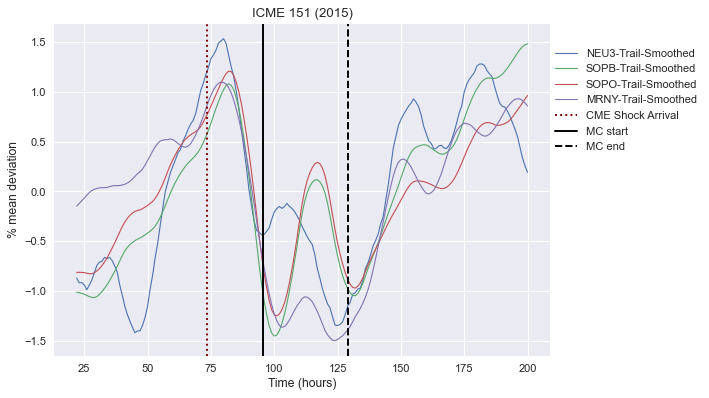

Predip_avg (NEU3, SOPB, SOPO, MRNY) =  [-0.46280284 -0.42054709 -0.15663811  0.25459658]
Local minima (NEU3, SOPB, SOPO, MRNY) =  [-1.34234423 -1.44778308 -1.24671445 -1.49466214]
FD magnitude (NEU3, SOPB, SOPO, MRNY) =  [0.87954138 1.02723599 1.09007634 1.74925872]


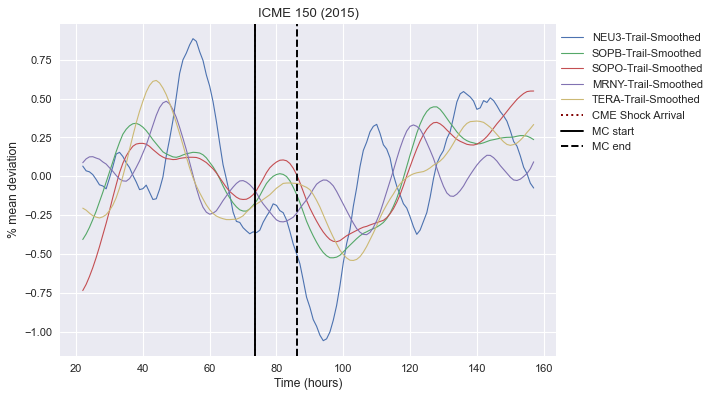

Predip_avg (NEU3, SOPB, SOPO, MRNY, TERA) =  [ 0.1517853   0.05027777 -0.0384981   0.07184055  0.02524864]
Local minima (NEU3, SOPB, SOPO, MRNY, TERA) =  [-0.49720998 -0.1867     -0.11843    -0.29300398 -0.1911132 ]
FD magnitude (NEU3, SOPB, SOPO, MRNY, TERA) =  [0.64899528 0.23697777 0.0799319  0.36484454 0.21636184]


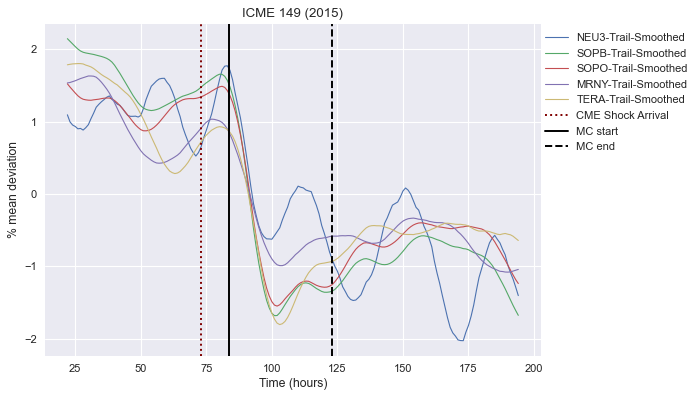

Predip_avg (NEU3, SOPB, SOPO, MRNY, TERA) =  [1.1429314  1.56248198 1.20070387 0.98665383 1.13118027]
Local minima (NEU3, SOPB, SOPO, MRNY, TERA) =  [-0.80329382 -1.68365396 -1.55079136 -0.99157027 -1.80650085]
FD magnitude (NEU3, SOPB, SOPO, MRNY, TERA) =  [1.94622523 3.24613593 2.75149523 1.97822409 2.93768112]


In [12]:

# TERA data has null values
analyzeNSSM("2015_lowrig_151.txt", "All", 12, "Percentdev_smooth", "ICME 151 (2015)", 73.6, 95.67, 129.03)

analyzeNSSMT("2015_lowrig_150.txt", "All", 12, "Percentdev_smooth", "ICME 150 (2015)", 73.59, 73.59, 86.05)

analyzeNSSMT("2015_lowrig_149.txt", "All", 12, "Percentdev_smooth", "ICME 149 (2015)", 73.09, 83.52, 122.87)



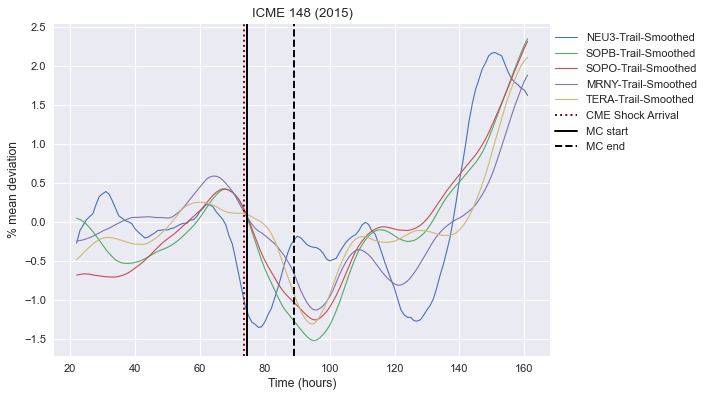

Predip_avg (NEU3, SOPB, SOPO, MRNY, TERA) =  [-0.00592214 -0.1496859  -0.25609251  0.13158402 -0.07767786]
Local minima (NEU3, SOPB, SOPO, MRNY, TERA) =  [-1.35608456 -1.27579859 -1.03807008 -0.66281931 -0.92688792]
FD magnitude (NEU3, SOPB, SOPO, MRNY, TERA) =  [1.35016242 1.1261127  0.78197757 0.79440333 0.84921006]


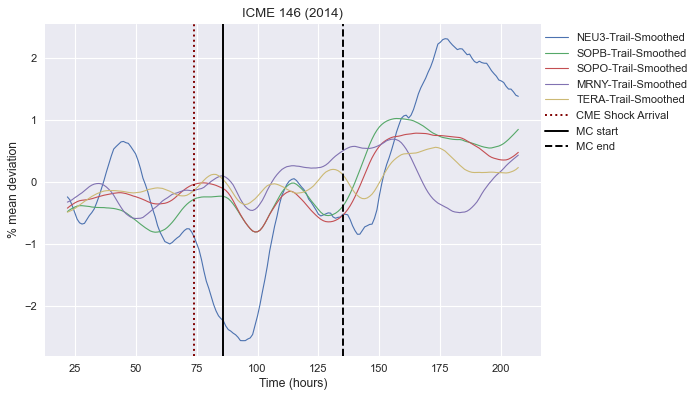

Predip_avg (NEU3, SOPB, SOPO, MRNY, TERA) =  [-0.25642774 -0.53275673 -0.25807755 -0.28189235 -0.20255763]
Local minima (NEU3, SOPB, SOPO, MRNY, TERA) =  [-2.55819349 -0.80657083 -0.80604673 -0.45859143 -0.36412502]
FD magnitude (NEU3, SOPB, SOPO, MRNY, TERA) =  [2.30176576 0.2738141  0.54796917 0.17669907 0.16156739]


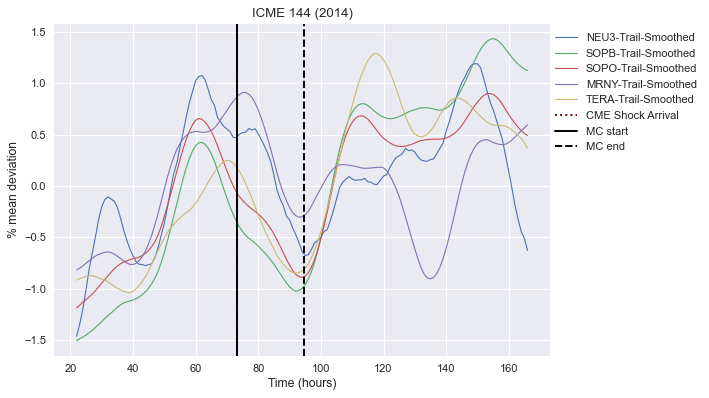

Predip_avg (NEU3, SOPB, SOPO, MRNY, TERA) =  [-0.0765671  -0.63594568 -0.30994975 -0.13562381 -0.53651624]
Local minima (NEU3, SOPB, SOPO, MRNY, TERA) =  [-0.63898415 -1.02482947 -0.89028098 -0.30421858 -0.84909258]
FD magnitude (NEU3, SOPB, SOPO, MRNY, TERA) =  [0.56241706 0.38888379 0.58033123 0.16859477 0.31257634]


In [5]:

analyzeNSSMT("2015_lowrig_148.txt", "All", 12, "Percentdev_smooth", "ICME 148 (2015)", 73.63, 74.47, 89.12)

# TERA data has null values
#analyzeNSSM("2014_lowrig_147.txt", "All", 12, "Percentdev_smooth", "ICME 147 (2014)",73.66, 98.12, 116.82)

analyzeNSSMT("2014_lowrig_146.txt", "All", 12, "Percentdev_smooth", "ICME 146 (2014)",73.82, 85.98, 135.15)

# TERA, NEU3 data has null values
#analyze5("2014_lowrig_145.txt", "All", 12, "Percentdev_smooth", "ICME 145 (2014)",)

analyzeNSSMT("2014_lowrig_144.txt", "All", 12, "Percentdev_smooth", "ICME 144 (2014)", 73.18, 73.18, 94.55)



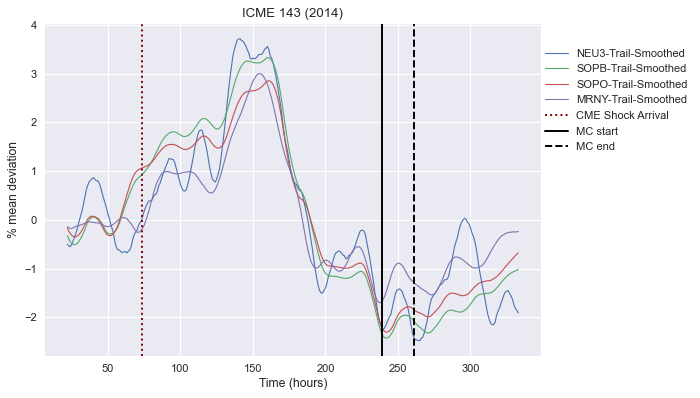

Predip_avg (NEU3, SOPB, SOPO, MRNY) =  [-0.03078322 -0.00705931  0.0658769  -0.0910963 ]
Local minima (NEU3, SOPB, SOPO, MRNY) =  [-2.41224107 -2.42584759 -2.30621098 -1.69735852]
FD magnitude (NEU3, SOPB, SOPO, MRNY) =  [2.38145786 2.41878828 2.37208788 1.60626222]


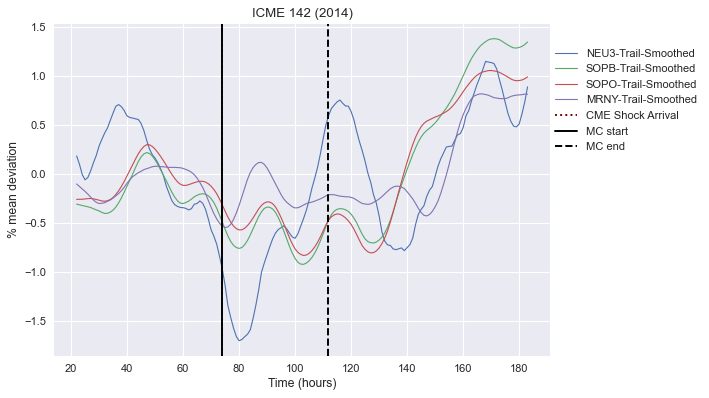

Predip_avg (NEU3, SOPB, SOPO, MRNY) =  [ 0.07696901 -0.18309529 -0.06124073 -0.09799396]
Local minima (NEU3, SOPB, SOPO, MRNY) =  [-1.70371304 -0.92393148 -0.83339598 -0.5474255 ]
FD magnitude (NEU3, SOPB, SOPO, MRNY) =  [1.78068204 0.74083619 0.77215525 0.44943153]


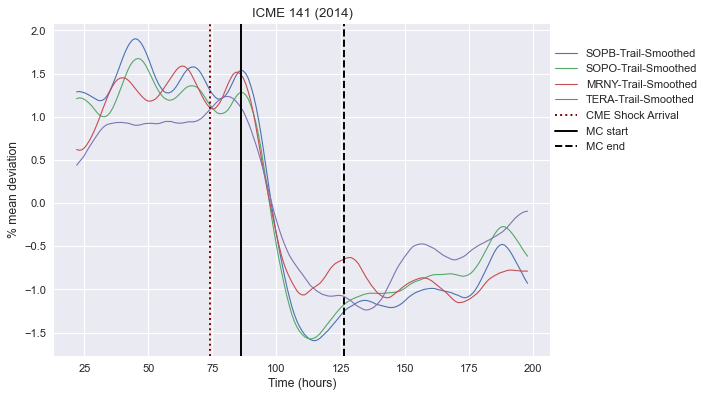

Predip_avg (SOPB, SOPO, MRNY, TERA) =  [1.46944303 1.29803596 1.23357262 0.87126622]
Local minima (SOPB, SOPO, MRNY, TERA) =  [-1.5935985  -1.57234126 -1.06319477 -1.07798892]
FD magnitude (SOPB, SOPO, MRNY, TERA) =  [3.06304153 2.87037722 2.29676739 1.94925515]


In [6]:
# 4 null values in TERA data
analyzeNSSM("2014_lowrig_143.txt", "All", 12, "Percentdev_smooth", "ICME 143 (2014)", 73.33, 238.68, 261.2)

# 4 null values in TERA data
analyzeNSSM("2014_lowrig_142.txt", "All", 12, "Percentdev_smooth", "ICME 142 (2014)", 73.95, 73.95, 111.87)

analyzeSSMT("2014_lowrig_141.txt", "All", 12, "Percentdev_smooth", "ICME 141 (2014)", 73.97, 86.30, 126.40)


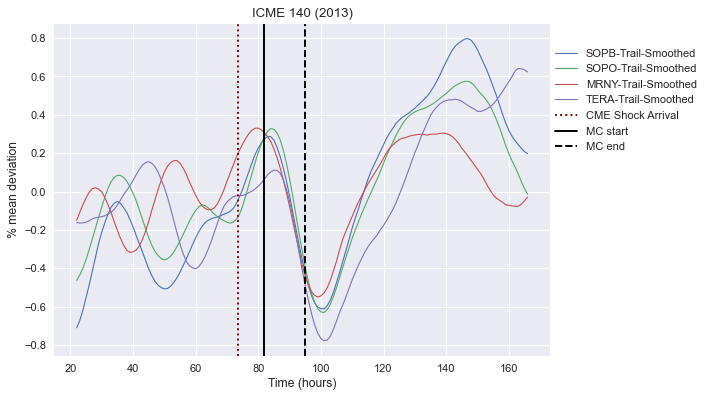

Predip_avg (SOPB, SOPO, MRNY, TERA) =  [-0.29223725 -0.16310214 -0.05483015 -0.11163669]
Local minima (SOPB, SOPO, MRNY, TERA) =  [-0.35210642 -0.3074578  -0.38064011 -0.40607731]
FD magnitude (SOPB, SOPO, MRNY, TERA) =  [0.05986916 0.14435566 0.32580996 0.29444062]


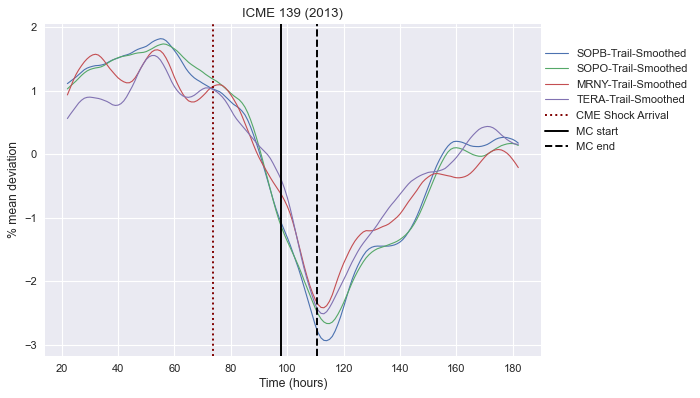

Predip_avg (SOPB, SOPO, MRNY, TERA) =  [1.46273916 1.46309493 1.26495763 1.01999411]
Local minima (SOPB, SOPO, MRNY, TERA) =  [-2.69493025 -2.42541497 -2.28970165 -2.36883636]
FD magnitude (SOPB, SOPO, MRNY, TERA) =  [4.15766941 3.88850989 3.55465928 3.38883048]


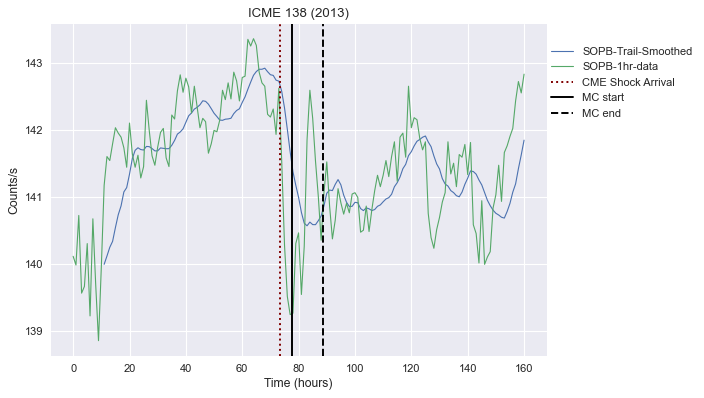

In [14]:
## 2013 plots

analyzeSSMT("2013_lowrig_140.txt", "All", 12, "Percentdev_smooth", "ICME 140 (2013)", 73.60, 81.78, 94.98)

analyzeSSMT("2013_lowrig_139.txt", "All", 12, "Percentdev_smooth", "ICME 139 (2013)", 73.78, 97.78, 110.5)

analyzeSSMT("2013_lowrig_138.txt", "SOPB", 12, "Smoothed", "ICME 138 (2013)", 73.23, 77.78, 88.58)


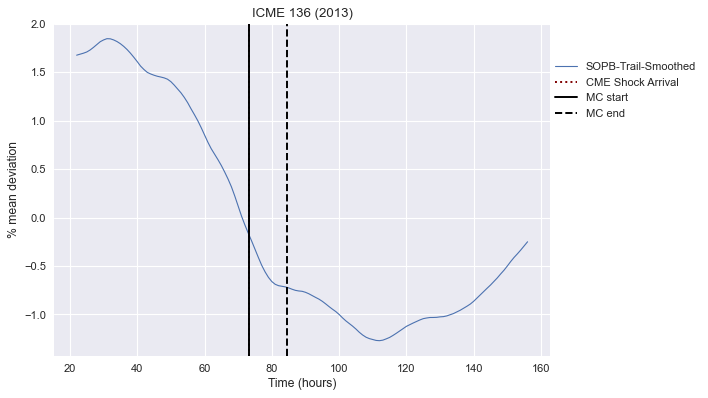

Predip_avg =  1.2566815380803116
Local minima =  -0.7157730183249548
FD magnitude =  1.9724545564052662


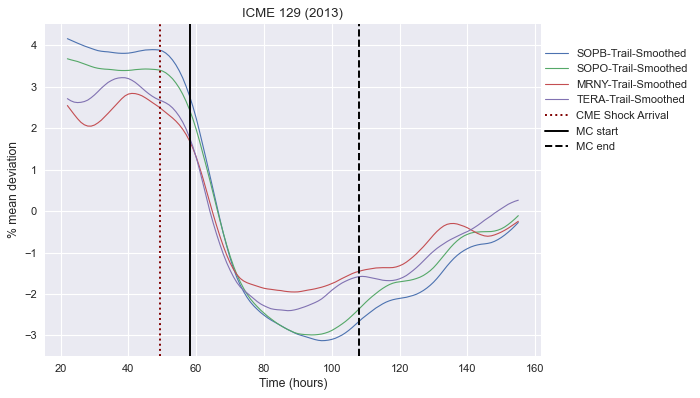

Predip_avg (SOPB, SOPO, MRNY, TERA) =  [3.90566517 3.46768008 2.46939662 2.91717266]
Local minima (SOPB, SOPO, MRNY, TERA) =  [-3.12751783 -2.98842765 -1.95236631 -2.40347956]
FD magnitude (SOPB, SOPO, MRNY, TERA) =  [7.033183   6.45610773 4.42176292 5.32065222]


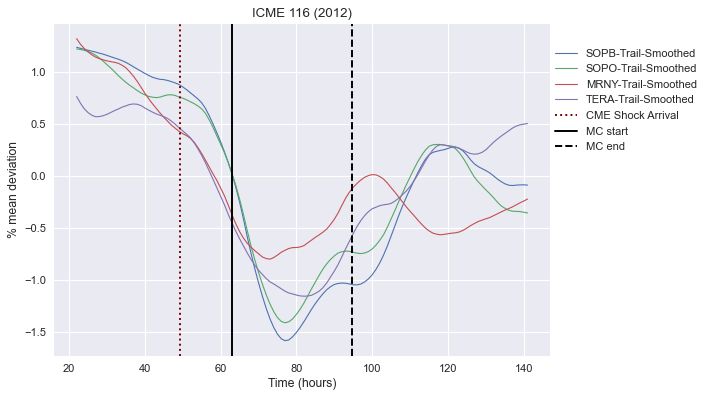

Predip_avg (SOPB, SOPO, MRNY, TERA) =  [1.06874645 0.94359014 0.93290573 0.61899331]
Local minima (SOPB, SOPO, MRNY, TERA) =  [-1.58485839 -1.41307998 -0.80221125 -1.15771727]
FD magnitude (SOPB, SOPO, MRNY, TERA) =  [2.65360484 2.35667012 1.73511697 1.77671058]


In [8]:
## No data for MRNY station
#analyzeSSMT("2013_lowrig_138.txt", "All", 12, "Percentdev_smooth", "ICME 138 (2013)", 73.12, 76.98, 83.24)

### MRNY data has 0 values for % mean dev data for MRNY is faulty
analyzeSSMT("2013_lowrig_136.txt", "SOPB", 12, "Percentdev_smooth", "ICME 136 (2013)", 73.23, 73.23, 84.50)

analyzeSSMT("2013_lowrig.txt", "All", 12, "Percentdev_smooth", "ICME 129 (2013)", 49.35, 58.15, 108.07)

analyzeSSMT("2012_lowrig.txt", "All", 12, "Percentdev_smooth", "ICME 116 (2012)", 49.18, 62.87, 94.78)

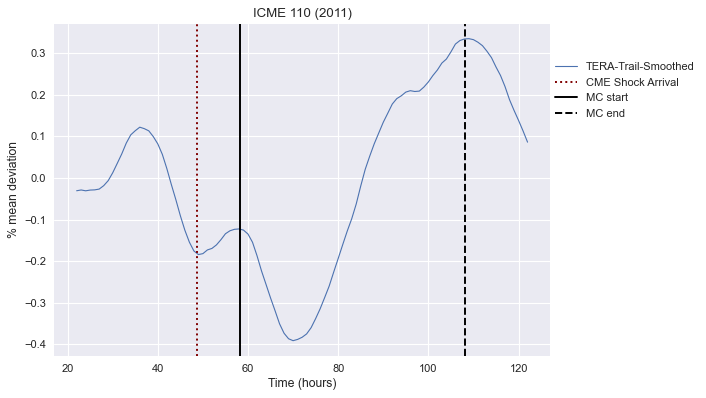

Predip_avg =  0.014750937598928645
Local minima =  -0.39111484251663237
FD magnitude =  0.405865780115561


In [9]:

analyzeSSMT("2011_lowrig.txt", "TERA", 12, "Percentdev_smooth", "ICME 110 (2011)", 48.70, 58.15, 108.07)

## Questions & contentions - 

Locations of NM stations, Delta B/B, Delta B, B, Vsw, Bmax, DST, Central moving average 


1) What should be an optimal smoothing window length for the NM data? Why 12 hours? Should % mean deviation also be smoothed again? -

Read somewhere that it should be slightly wider than widest "interesting" peak/valley in the data. Also that derivatives tend to amplify the noise in the data, so only take derivatives of smoothed data if at all necessary.

2) What kind of moving average is appropriate? Trailing, Central, or Something else? Also do we need to adjust the ICME times after smoothing out data, depending on the kind of smoothing done?

3) Visually, +ve corrections of length "window" for %dev_smooth, "window/2" for %dev_raw and simple trail-smoothed data in the shock and MC timings are seeming to be appropriate at capturing the dip inside the boundaries. However, should there even be a correction? If yes, of what magnitude? 

3) How are the start and end times of MCs and CME shock arrivals calculated in Bhattacharjee et al (2022)? Directly obtained from WIND spacecraft? Christopher Light et al has an interesting method to calculate start and end times for quick decreases in NM data i.e. potential FDs. How does WIND do this? 


### Stack overflow important post on finding peaks in numpy 1D array data - 

The locations of local maxima and minima are also the locations of the zero crossings of the first derivative. It is generally much easier to find zero crossings than it is to directly find local maxima and minima.

Unfortunately, the first derivative tends to "amplify" noise, so when significant noise is present in the original data, the first derivative is best used only after the original data has had some degree of smoothing applied.

Since smoothing is, in the simplest sense, a low pass filter, the smoothing is often best (well, most easily) done by using a convolution kernel, and "shaping" that kernel can provide a surprising amount of feature-preserving/enhancing capability. The process of finding an optimal kernel can be automated using a variety of means, but the best may be simple brute force (plenty fast for finding small kernels). A good kernel will (as intended) massively distort the original data, but it will NOT affect the location of the peaks/valleys of interest.

Fortunately, quite often a suitable kernel can be created via a simple SWAG ("educated guess"). The width of the smoothing kernel should be a little wider than the widest expected "interesting" peak in the original data, and its shape will resemble that peak (a single-scaled wavelet). For mean-preserving kernels (what any good smoothing filter should be) the sum of the kernel elements should be precisely equal to 1.00, and the kernel should be symmetric about its center (meaning it will have an odd number of elements.

Given an optimal smoothing kernel (or a small number of kernels optimized for different data content), the degree of smoothing becomes a scaling factor for (the "gain" of) the convolution kernel.

Determining the "correct" (optimal) degree of smoothing (convolution kernel gain) can even be automated: Compare the standard deviation of the first derivative data with the standard deviation of the smoothed data. How the ratio of the two standard deviations changes with changes in the degree of smoothing cam be used to predict effective smoothing values. A few manual data runs (that are truly representative) should be all that's needed.

All the prior solutions posted above compute the first derivative, but they don't treat it as a statistical measure, nor do the above solutions attempt to performing feature preserving/enhancing smoothing (to help subtle peaks "leap above" the noise).

Finally, the bad news: Finding "real" peaks becomes a royal pain when the noise also has features that look like real peaks (overlapping bandwidth). The next more-complex solution is generally to use a longer convolution kernel (a "wider kernel aperture") that takes into account the relationship between adjacent "real" peaks (such as minimum or maximum rates for peak occurrence), or to use multiple convolution passes using kernels having different widths (but only if it is faster: it is a fundamental mathematical truth that linear convolutions performed in sequence can always be convolved together into a single convolution). But it is often far easier to first find a sequence of useful kernels (of varying widths) and convolve them together than it is to directly find the final kernel in a single step.